# **Pairs Trading**

Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive correlation. It is a form of **statistical arbitrage** i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards). Instead, pairs trading works on the concept of mean-reversion. When two highly correlated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

## **Importing Libraries**

In [1]:
!pip install yfinance


In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=ff82dde0d925616b763fce762abe0c4da71ee9db31a46e77484b23c78c5dd0f4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
!pip install backtesting bokeh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=2a4e4e8d1803ea80ff6eadd72c5703dc8c2816d47ec81428559b55e144f25ac4
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm
import backtesting
from backtesting import Backtest
from backtesting.lib import crossover
import bokeh

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [5]:
backtesting.set_bokeh_output(notebook=False)

## **Importing Stock Price dataset**

For the purpose of this strategy, a lookback period of four years from 2018-2022 will be used to identify stock pairs having high positive correlation. In particular, stocks from the banking sector will be considered and hence the stocks of the BANK NIFTY index have been taken.


In [6]:
start_date = "2018-12-31"
end_date = "2022-12-31"

stocks = ["INDUSINDBK.NS", "HDFCBANK.NS", "PNB.NS", "ICICIBANK.NS", "BANKBARODA.NS", "SBIN.NS", "IDFCFIRSTB.NS", "KOTAKBANK.NS", "FEDERALBNK.NS", "AXISBANK.NS", "AUBANK.NS"]

In [7]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[*********************100%%**********************]  11 of 11 completed


Ticker,AUBANK.NS,AXISBANK.NS,BANKBARODA.NS,FEDERALBNK.NS,HDFCBANK.NS,ICICIBANK.NS,IDFCFIRSTB.NS,INDUSINDBK.NS,KOTAKBANK.NS,PNB.NS,SBIN.NS
Date,,,,,,,,,,,
2018-12-31,310.026154,617.559937,111.988968,89.028755,1009.855164,353.179321,43.349998,1553.385498,1253.412476,75.445885,278.514191
2019-01-01,309.951416,624.931946,116.230972,88.790077,1022.420837,356.709686,43.349998,1549.791626,1247.377319,77.088112,281.996765
2019-01-02,309.104218,617.709351,112.507431,90.508591,1013.091797,357.543243,42.700001,1531.337158,1237.551636,75.204384,276.631714
2019-01-03,309.652374,605.654968,112.460297,87.835335,1005.143066,356.219360,43.049999,1515.310913,1232.214600,75.204384,273.996246
2019-01-04,310.898254,617.260986,114.722694,90.508591,1007.832336,358.131592,45.150002,1503.752563,1244.883545,78.537140,280.161377


In [8]:
stock_data

Ticker,AUBANK.NS,AXISBANK.NS,BANKBARODA.NS,FEDERALBNK.NS,HDFCBANK.NS,ICICIBANK.NS,IDFCFIRSTB.NS,INDUSINDBK.NS,KOTAKBANK.NS,PNB.NS,SBIN.NS
Date,,,,,,,,,,,
2018-12-31,310.026154,617.559937,111.988968,89.028755,1009.855164,353.179321,43.349998,1553.385498,1253.412476,75.445885,278.514191
2019-01-01,309.951416,624.931946,116.230972,88.790077,1022.420837,356.709686,43.349998,1549.791626,1247.377319,77.088112,281.996765
2019-01-02,309.104218,617.709351,112.507431,90.508591,1013.091797,357.543243,42.700001,1531.337158,1237.551636,75.204384,276.631714
2019-01-03,309.652374,605.654968,112.460297,87.835335,1005.143066,356.219360,43.049999,1515.310913,1232.214600,75.204384,273.996246
2019-01-04,310.898254,617.260986,114.722694,90.508591,1007.832336,358.131592,45.150002,1503.752563,1244.883545,78.537140,280.161377
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,654.188354,927.753296,171.973434,129.775711,1589.273193,885.907837,55.650002,1182.724854,1812.057983,52.818138,576.057739
2022-12-27,662.477417,931.249695,172.458954,131.959305,1590.882568,893.296997,55.950001,1189.302734,1819.401978,53.509216,580.688599
2022-12-28,662.327637,923.757385,176.537369,132.654083,1589.614624,891.610901,55.849998,1200.974731,1818.602539,54.200298,579.868530


Let's plot some stock prices!

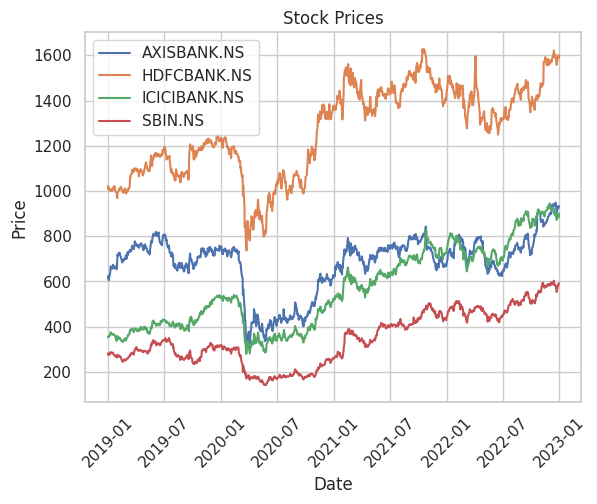

In [9]:
plt.plot(stock_data[['AXISBANK.NS','HDFCBANK.NS','ICICIBANK.NS','SBIN.NS']])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Prices")
plt.legend(['AXISBANK.NS','HDFCBANK.NS','ICICIBANK.NS','SBIN.NS'])


## **Identifying stock pairs**

### **Cointegration**

Cointegration is a statistical method which is used to identify the correlation between two non-stationary time series in the long run or over a specified period.

**Finding stock pairs with cointegrated time series:**

In [10]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval

        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs

<Axes: >

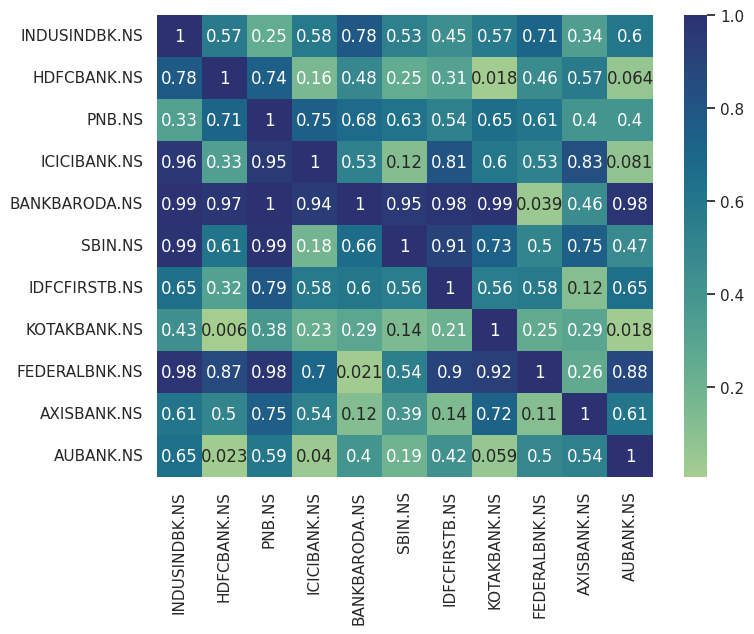

In [11]:
pvalues, stock_pairs = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)

The pairs of stocks having a cointegration are those with a p-value less than the threshold of 0.05.
P-value can be considered as a measure of the strength of cointegration between the two series. A lower p-value indicates a stronger cointegration

In [12]:
min(stock_pairs)

(0.006010499346640932, ('KOTAKBANK.NS', 'HDFCBANK.NS'))

In [79]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
import matplotlib.pyplot as plt

def johansen_cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    pairs = list(itertools.combinations(range(N), 2))

    for pair in pairs:
        i, j = pair
        y1 = stock_data.iloc[:, i]
        y2 = stock_data.iloc[:, j]

        result = coint_johansen(stock_data[[stocks[i], stocks[j]]], det_order=0, k_ar_diff=1)
        test_stat = result.lr1[0]  # Use the first statistic
        critical_value = result.cvt[0, 1]  # Use the 95% critical value

        pval = 1.0 if test_stat < critical_value else 0.0
        pvalues[i, j] = pval
        pvalues[j, i] = pval

        if pval == 0.0 and stocks[i] != stocks[j]:
            stock_pairs.append((test_stat, (stocks[i], stocks[j])))

    return pvalues, stock_pairs





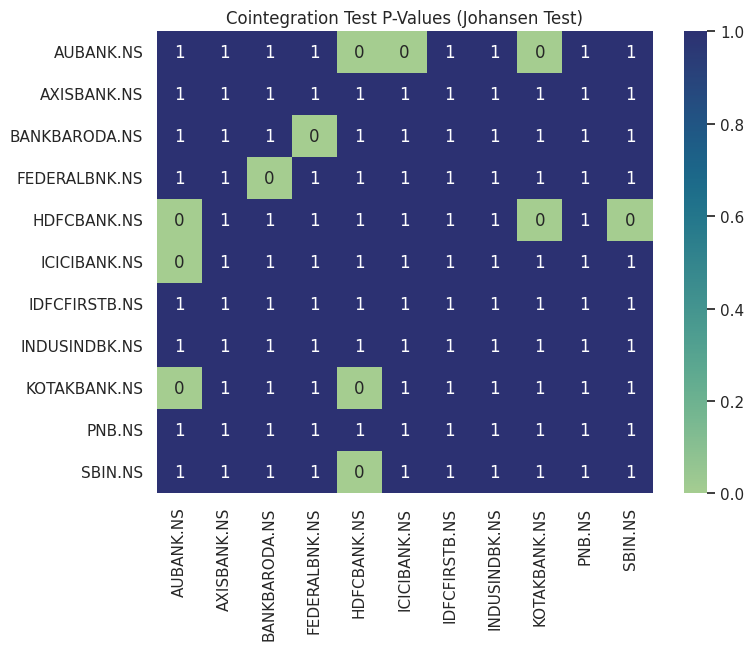

Significant cointegrated pairs at 95% confidence level: [(28.983491798351622, ('AUBANK.NS', 'HDFCBANK.NS')), (16.738101782015665, ('AUBANK.NS', 'ICICIBANK.NS')), (21.055391516176755, ('AUBANK.NS', 'KOTAKBANK.NS')), (18.399805994550576, ('BANKBARODA.NS', 'FEDERALBNK.NS')), (24.08465624576846, ('HDFCBANK.NS', 'KOTAKBANK.NS')), (17.13201366936788, ('HDFCBANK.NS', 'SBIN.NS'))]


In [14]:
stocks = stock_data.columns.tolist()

pvalues, stock_pairs = johansen_cointegration_test(stock_data, stocks)

# Plot the heatmap
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels=stocks, yticklabels=stocks, cmap='crest', annot=True)
plt.title('Cointegration Test P-Values (Johansen Test)')
plt.show()

# Print the significant pairs
print(f"Significant cointegrated pairs at 95% confidence level: {stock_pairs}")


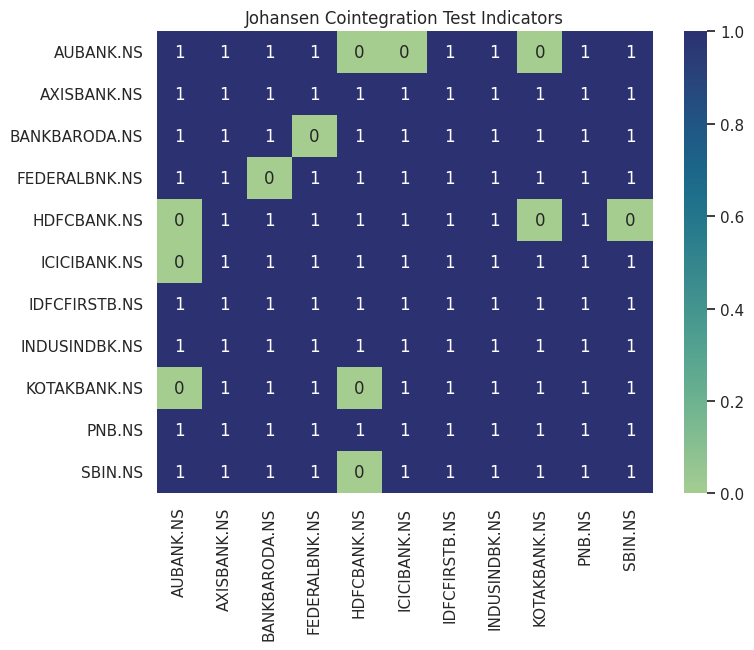

Significant cointegrated pairs (Johansen, 95% confidence level): [(28.983491798351622, ('AUBANK.NS', 'HDFCBANK.NS')), (16.738101782015665, ('AUBANK.NS', 'ICICIBANK.NS')), (21.055391516176755, ('AUBANK.NS', 'KOTAKBANK.NS')), (18.399805994550576, ('BANKBARODA.NS', 'FEDERALBNK.NS')), (24.08465624576846, ('HDFCBANK.NS', 'KOTAKBANK.NS')), (17.13201366936788, ('HDFCBANK.NS', 'SBIN.NS'))]


In [51]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# Function for the Johansen test
def johansen_cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i, j in itertools.combinations(range(N), 2):
        result = coint_johansen(stock_data[[stocks[i], stocks[j]]], det_order=0, k_ar_diff=1)
        test_stat = result.lr1[0]  # Using the first statistic
        critical_value = result.cvt[0, 1]  # Using the 95% critical value

        # Johansen does not provide p-values directly, so we use test_stat and critical value
        pval = 1.0 if test_stat < critical_value else 0.0
        pvalues[i, j] = pval
        pvalues[j, i] = pval

        if pval == 0.0:
            stock_pairs.append((test_stat, (stocks[i], stocks[j])))

    return pvalues, stock_pairs


stocks = stock_data.columns.tolist()

# Performing the Johansen cointegration test
johansen_pvalues, johansen_stock_pairs = johansen_cointegration_test(stock_data, stocks)

# Plotting the Johansen heatmap
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(johansen_pvalues, xticklabels=stocks, yticklabels=stocks, cmap='crest', annot=True)
plt.title('Johansen Cointegration Test Indicators')
plt.show()

# Printing the significant pairs
print(f"Significant cointegrated pairs (Johansen, 95% confidence level): {johansen_stock_pairs}")


In [52]:
min(johansen_stock_pairs)

(16.738101782015665, ('AUBANK.NS', 'ICICIBANK.NS'))

**Selected pair: AUBANK Bank & ICICI Bank**

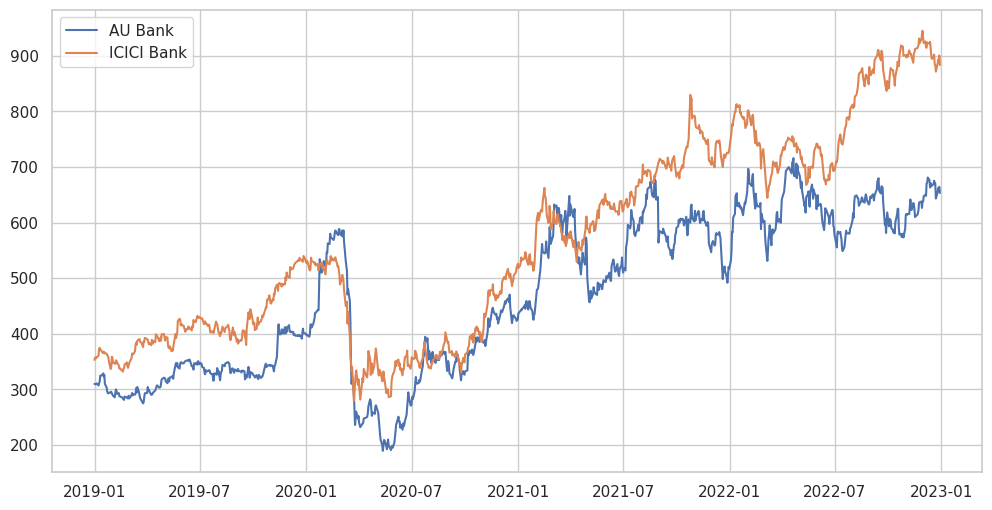

In [53]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data['AUBANK.NS'], label = 'AU Bank')
plt.plot(stock_data['ICICIBANK.NS'], label = 'ICICI Bank')
plt.legend()
plt.show()

Text(0, 0.5, 'ICICI Bank')

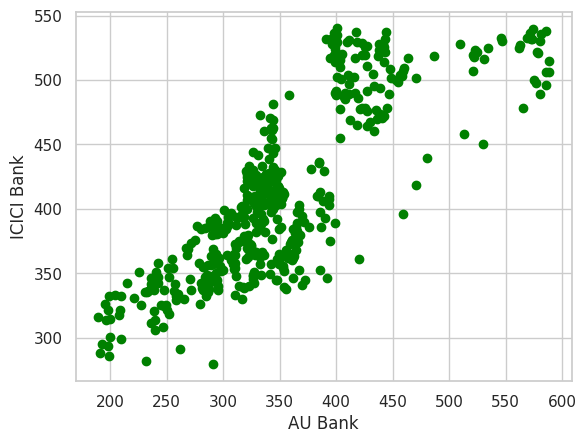

In [54]:
plt.scatter(stock_data['AUBANK.NS'].head(500),stock_data['ICICIBANK.NS'].head(500),c="green")
plt.xlabel("AU Bank")
plt.ylabel("ICICI Bank")

In [55]:
# Import libraries
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import itertools
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen

### Selecting the best pair

In [56]:

# Generate all possible pairs of columns
pairs = list(itertools.combinations(stock_data.columns, 2))

def johansen_test(y1, y2):
    data = pd.concat([y1, y2], axis=1)
    result = coint_johansen(data, det_order=0, k_ar_diff=1)
    return result.lr1, result.cvt  # Return the test statistics and critical values

results = []

for pair in pairs:
    y1 = stock_data[pair[0]]
    y2 = stock_data[pair[1]]
    test_stat, critical_values = johansen_test(y1, y2)
    results.append((pair, test_stat, critical_values))

best_pair = None
max_test_stat = -float('inf')

for result in results:
    pair, test_stat, critical_values = result
    # Check if the test statistic exceeds the critical values for significance levels (90%, 95%, 99%)
    if test_stat[0] > critical_values[0, 1]:  # Checking against the 90% critical value
        if test_stat[0] > max_test_stat:
            max_test_stat = test_stat[0]
            best_pair = pair

print(f"Best cointegrated pair: {best_pair} with test statistic {max_test_stat}")


Best cointegrated pair: ('AUBANK.NS', 'HDFCBANK.NS') with test statistic 28.983491798351622


### **Testing Data**

The strategy will use a 6 month testing period from January 2023 to June 2023. The spread between the prices of the two stocks will be used to determine points of entry and exit for the pairs trade.

[*********************100%%**********************]  2 of 2 completed


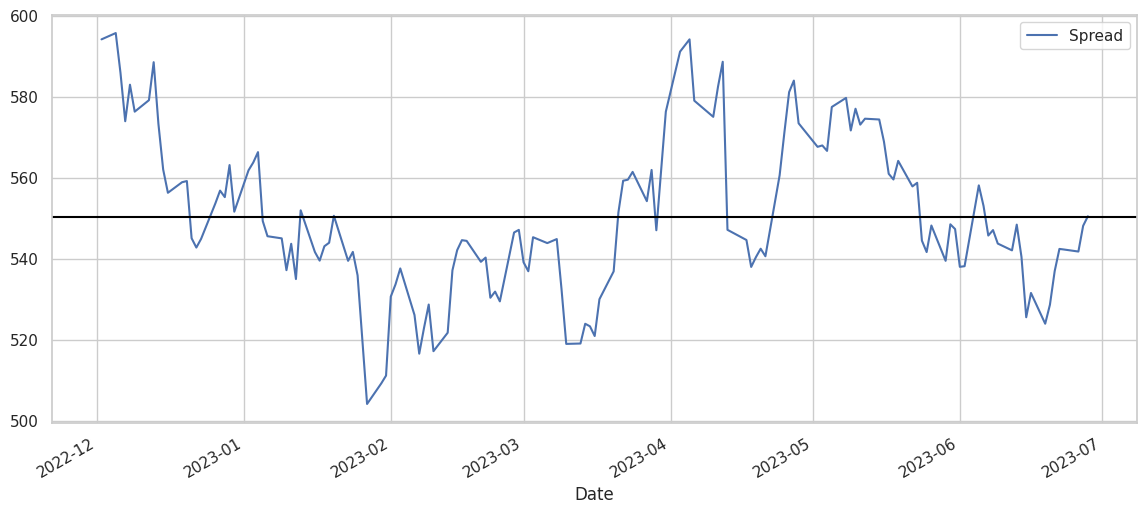

In [57]:

stock_pair = ['AUBANK.NS', 'ICICIBANK.NS']
asset_pairs =  yf.download(stock_pair, start="2022-12-02" ,end= "2023-06-30")['Adj Close']

S1=asset_pairs[stock_pair[0]]
S2=asset_pairs[stock_pair[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair[0]]
b = results.params[stock_pair[0]]

spread = S2 - b * S1
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

## **Z-Score**

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt values from data sets having a very different ranges to make scores that are comparable.
Essentially, z-scores can shrink a large range of values into a much smaller range which is easier to handle.

Zscore.svg

𝒳 = series

μ = series mean

σ = series standard deviation

In [29]:
def zscore(series):
    lookback = 20
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])


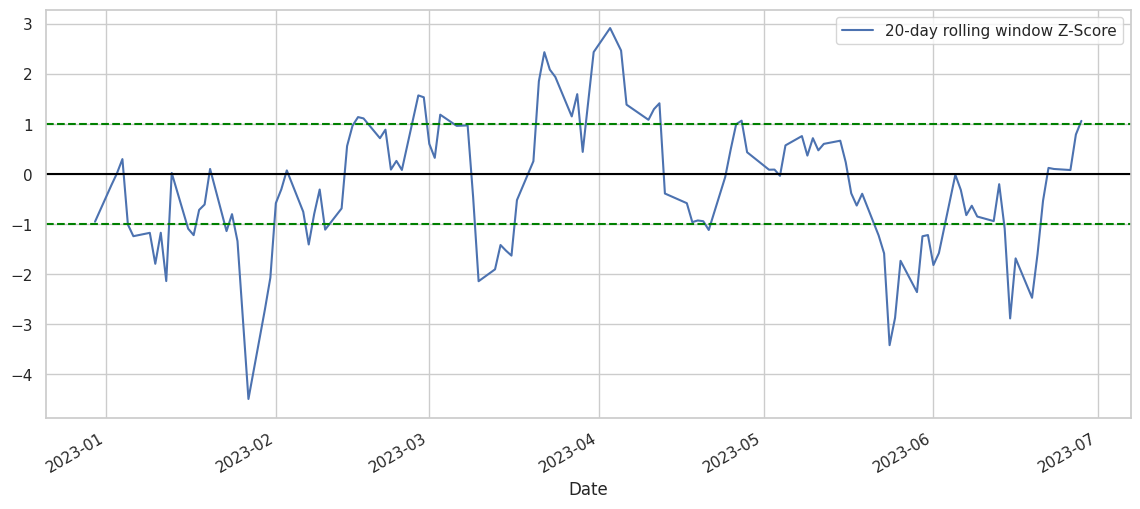

In [58]:
zscore(spread).plot(figsize=(14, 6))
plt.axhline(0, color='black')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

## **Trading Strategy**

Implementation of a simple mean-reversion based strategy. The threshold levels for the Z-score are taken as +1 and -1. Whenever the Z-score value rises above +1, it is expected to fall in the future and a short position is taken on the pair. Similarly, when the Z-score value falls below -1, it is expected to rise in the future and a long position is taken on the pair.


In [59]:

def generate_trade_signals(S1, S2, spread):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore(spread)

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

In [60]:
trade_signals = generate_trade_signals(S1, S2, spread)
trade_signals.dropna(inplace = True)
trade_signals

,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2023-01-02,656.135742,895.082336,561.843796,-0.219413,0,0.0,0,0.0
2023-01-03,650.193604,893.991272,563.770627,0.013426,0,0.0,0,0.0
2023-01-04,640.755981,891.759644,566.332183,0.298936,0,0.0,0,0.0
2023-01-05,635.263245,871.972534,549.334728,-1.009173,-1,-1.0,1,1.0
2023-01-06,624.976807,862.996399,545.582873,-1.242074,-1,0.0,1,0.0
...,...,...,...,...,...,...,...,...
2023-06-22,739.825500,918.192078,542.449142,0.122772,0,0.0,0,0.0
2023-06-23,735.730957,915.960449,542.297052,0.101341,0,0.0,0,0.0
2023-06-26,744.419495,919.878235,541.802099,0.080369,0,0.0,0,0.0


### **Visualising the positions**

**1) Trades on the pair**

In [61]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

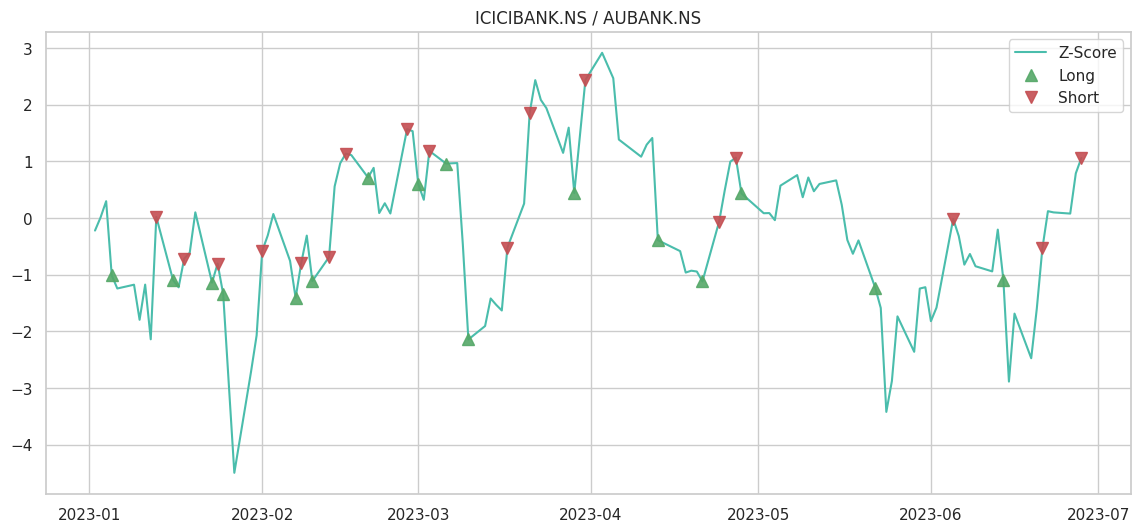

In [62]:
plot_pair_trades(trade_signals)

In [63]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

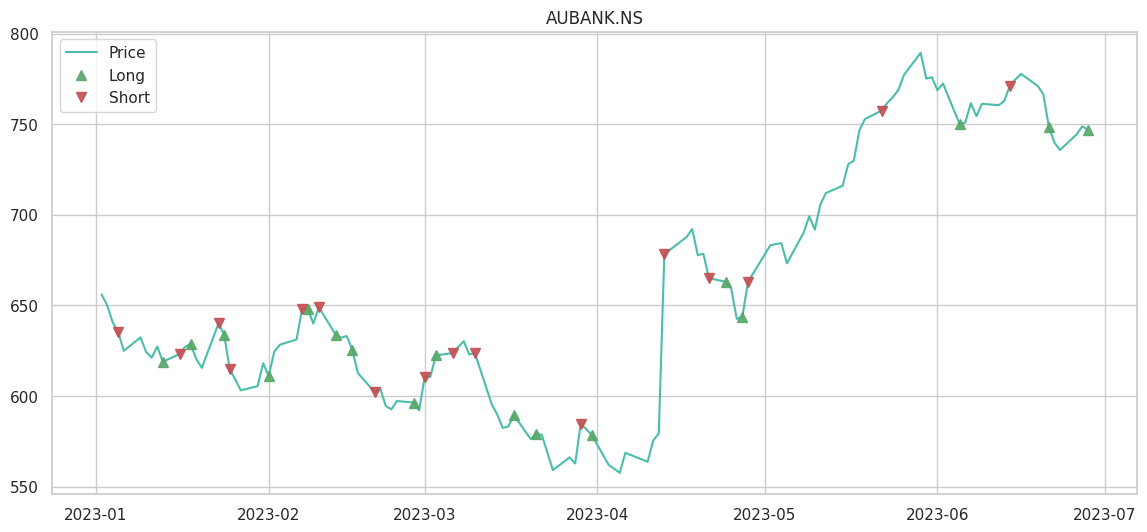

In [64]:
plot_trades_1(trade_signals)

In [65]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

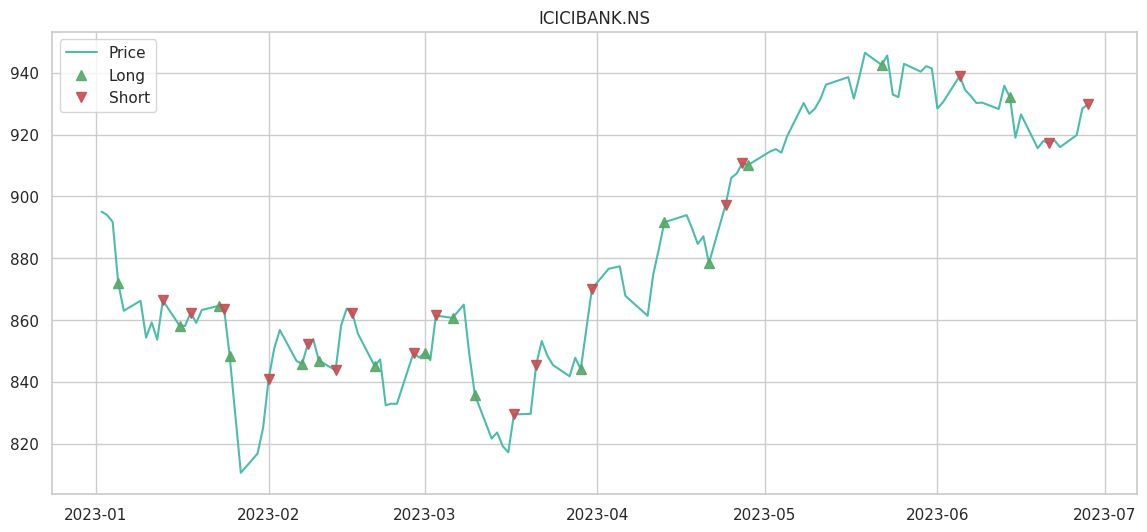

In [66]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [67]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [68]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2023-01-03,0.000000,50000.000000,50000.000000,0.000000,0.000000,50000.00000,50000.000000,0.000000,100000.000000
2023-01-04,0.000000,50000.000000,50000.000000,0.000000,0.000000,50000.00000,50000.000000,0.000000,100000.000000
2023-01-05,-48280.006592,98280.006592,50000.000000,0.000000,47958.489380,2041.51062,50000.000000,0.000000,100000.000000
2023-01-06,-47498.237305,98280.006592,50781.769287,0.015635,47464.801941,2041.51062,49506.312561,-0.009874,100288.081848
2023-01-09,-48059.896973,98280.006592,50220.109619,-0.011060,47642.091675,2041.51062,49683.602295,0.003581,99903.711914


In [69]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

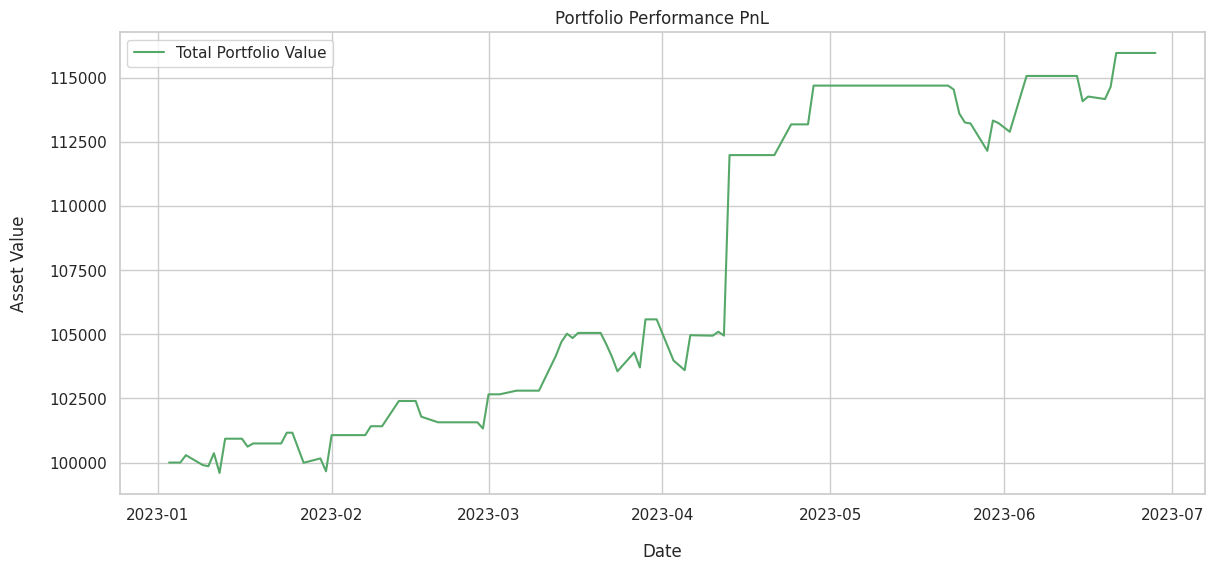

In [70]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [71]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [72]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  120
CAGR = 36.485%


Returns are also compared to a benchmark to assess the performance of the trading strategy in comparison to the overall market. For the purpose of this strategy, the NIFTY BANK index is taken as a benchmark.

[*********************100%%**********************]  1 of 1 completed


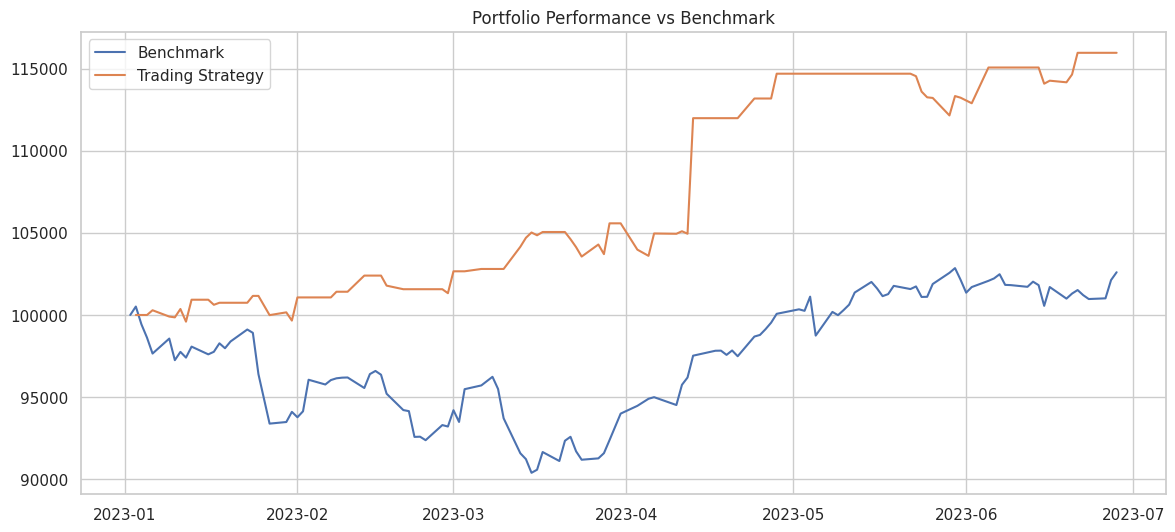

In [73]:
index = yf.download('^NSEBANK', start = '2023-01-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])

In [74]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of NIFTY Bank:", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of NIFTY Bank: 5.498 %
CAGR of trading strategy: 36.485 %


Backtesting

In [75]:
dstart="2018-12-02"
dend="2022-12-01"

In [76]:
def calculate_cagr_b(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252*4
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [77]:
def backtesting(dstart,dend):
    stock_pair_b = ['AUBANK.NS', 'ICICIBANK.NS']
    asset_pairs_b =  yf.download(stock_pair_b, start=dstart ,end=dend )['Adj Close']

    S1_b=asset_pairs_b[stock_pair_b[0]]
    S2_b=asset_pairs_b[stock_pair_b[1]]

    S1_b = sm.add_constant(S1_b)
    results_b = sm.OLS(S2_b, S1_b).fit()
    S1_b = S1_b[stock_pair_b[0]]
    b_b = results_b.params[stock_pair_b[0]]

    spread_b = S2_b - b_b * S1_b
    spread_b.plot(figsize=(14, 6))
    #print("Spread")
    plt.axhline(spread_b.mean(), color='black')
    plt.legend(['Spread'])
    trade_signals_b = generate_trade_signals(S1_b, S2_b, spread_b)
    trade_signals_b.dropna(inplace = True)
    trade_signals_b
    #print("On pair trade")
    plot_pair_trades(trade_signals_b)
    #print("KOTAKBANK")
    plot_trades_1(trade_signals_b)
    print()
    #print("HDFCBANK")
    plot_trades_2(trade_signals_b)
    print()
    portfolio_b = pnl_calculation(trade_signals_b)
    portfolio_b.head()
    plot_portfolio_value(portfolio_b)
    plot_portfolio_value(portfolio_b)
    print("**CAGR**")
    print('CAGR = {:.3f}%' .format(calculate_cagr_b(portfolio_b) * 100))
    print()
    index_b = yf.download('^NSEBANK', start = dstart, end = dend)['Adj Close']
    shares_b = 100000/index_b[0]

    plt.figure(figsize = (14, 6))
    plt.plot(index_b*shares_b)
    plt.plot(portfolio_b['total'])
    plt.title('Portfolio Performance vs Benchmark')
    plt.legend(['Benchmark', 'Trading Strategy'])
    cagr_index_b = (index_b.iloc[-1] / index_b[0])**((252*4)/len(index_b)) - 1
    print("CAGR of NIFTY vs Trading Strategy")
    print("CAGR of NIFTY Bank:", np.round(cagr_index_b*100, 3), "%")
    cagr_portfolio_b = (portfolio_b['total'][-1] / portfolio_b['total'][0]) ** ((252*4)/len(portfolio_b)) - 1
    print("CAGR of trading strategy:", np.round(cagr_portfolio_b*100, 3), "%")
    print()
    return trade_signals_b

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed



**CAGR**
Number of trading days =  966
CAGR = 36.888%

CAGR of NIFTY vs Trading Strategy
CAGR of NIFTY Bank: 62.925 %
CAGR of trading strategy: 36.888 %



,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2019-01-02,309.104187,357.543213,-0.446174,0.701564,0,0.0,0,0.0
2019-01-03,309.652374,356.219360,-2.404910,0.503165,0,0.0,0,0.0
2019-01-04,310.898285,358.131622,-1.935601,0.516189,0,0.0,0,0.0
2019-01-07,307.160614,360.583221,4.844786,1.150353,1,1.0,-1,-1.0
2019-01-08,310.499603,372.792236,13.186747,1.879591,1,0.0,-1,0.0
...,...,...,...,...,...,...,...,...
2022-11-24,635.512939,931.185120,195.165043,-0.060464,0,0.0,0,0.0
2022-11-25,636.911072,922.704895,185.065570,-0.388179,0,0.0,0,0.0
2022-11-28,637.909790,929.747009,190.951018,0.003475,0,0.0,0,0.0


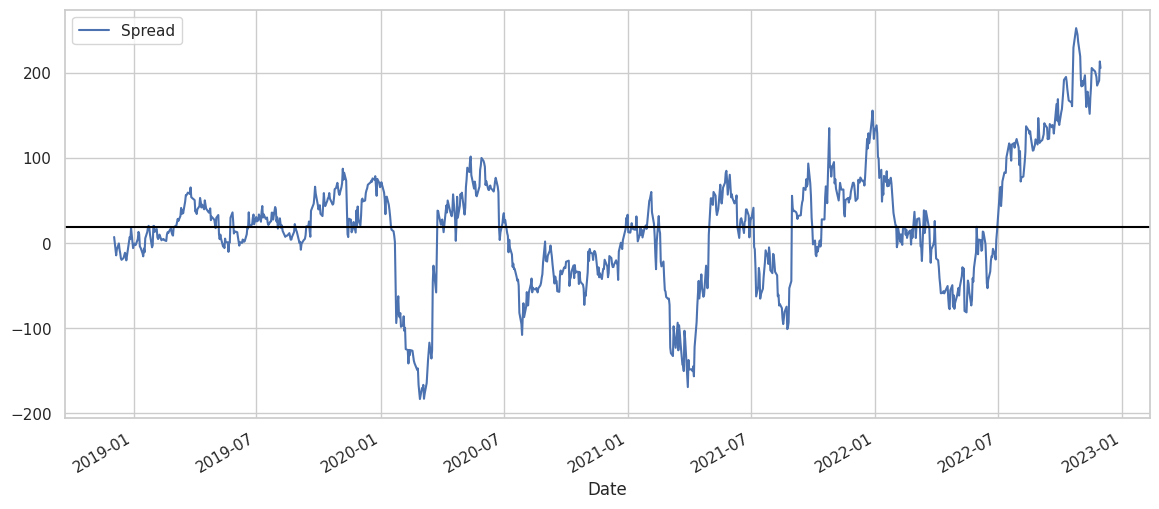

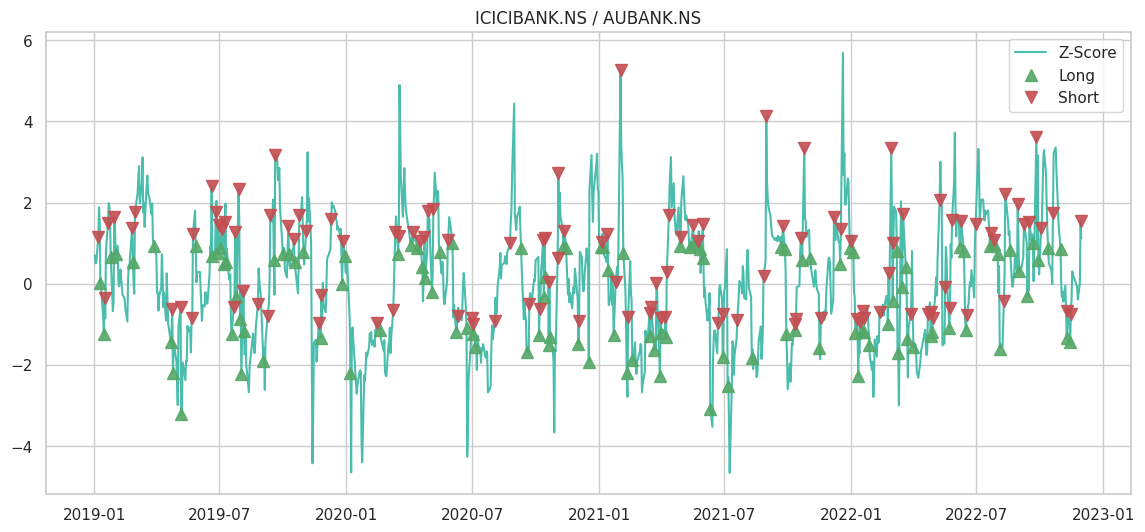

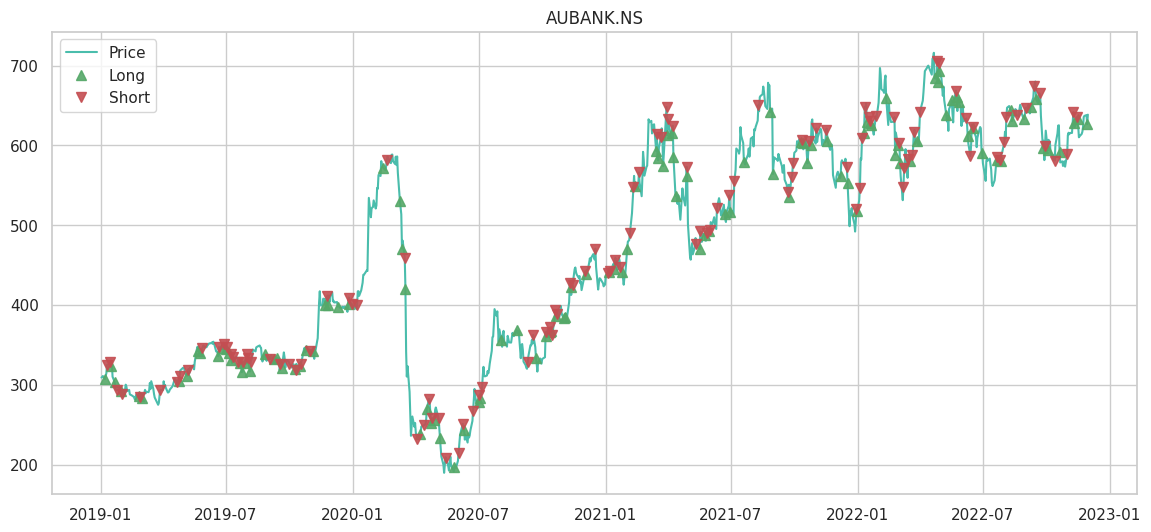

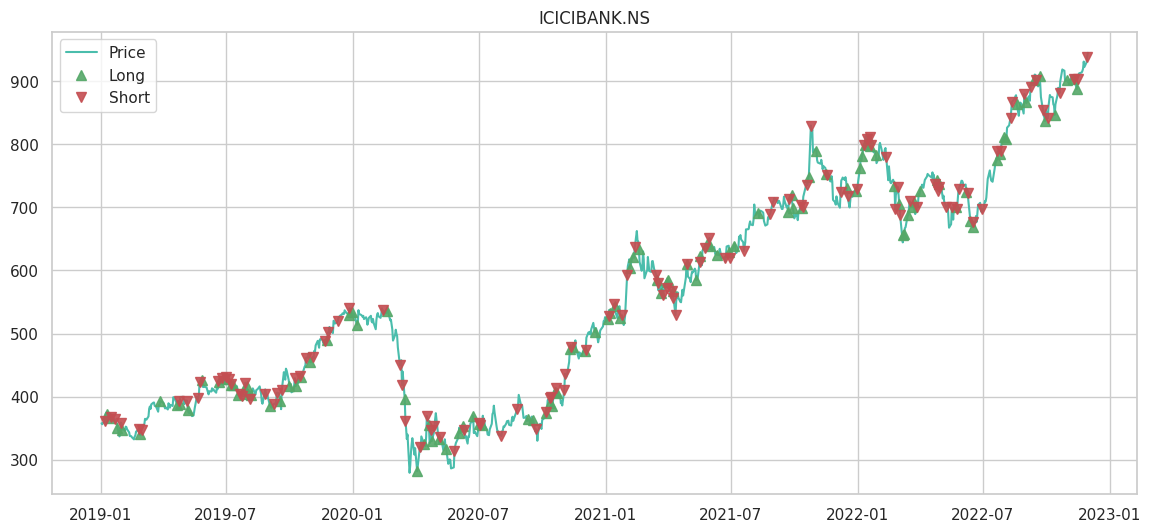

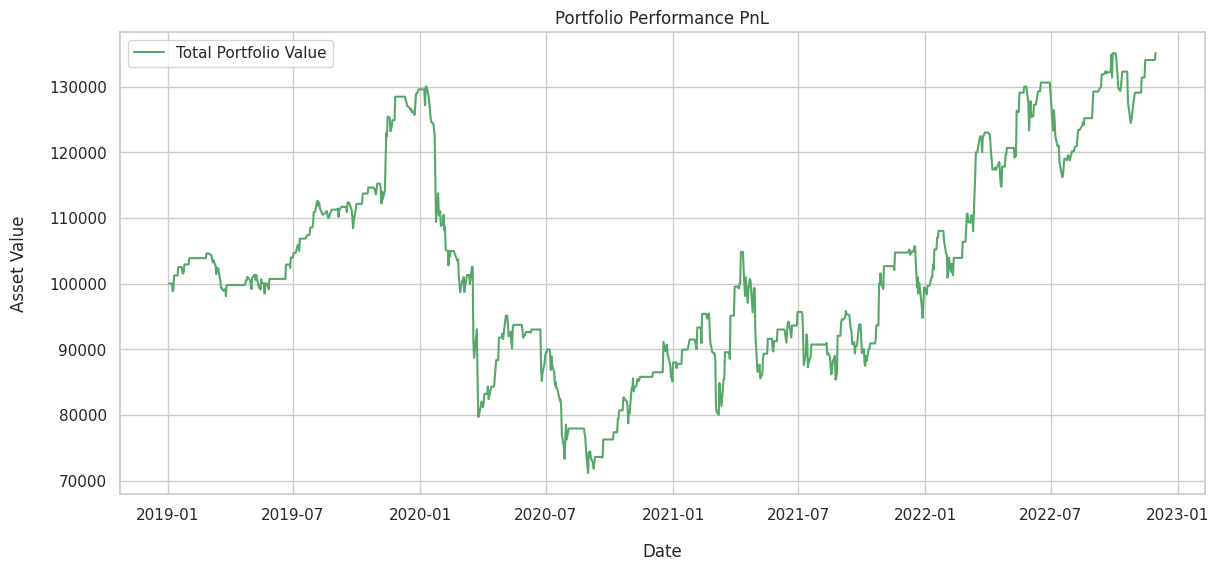

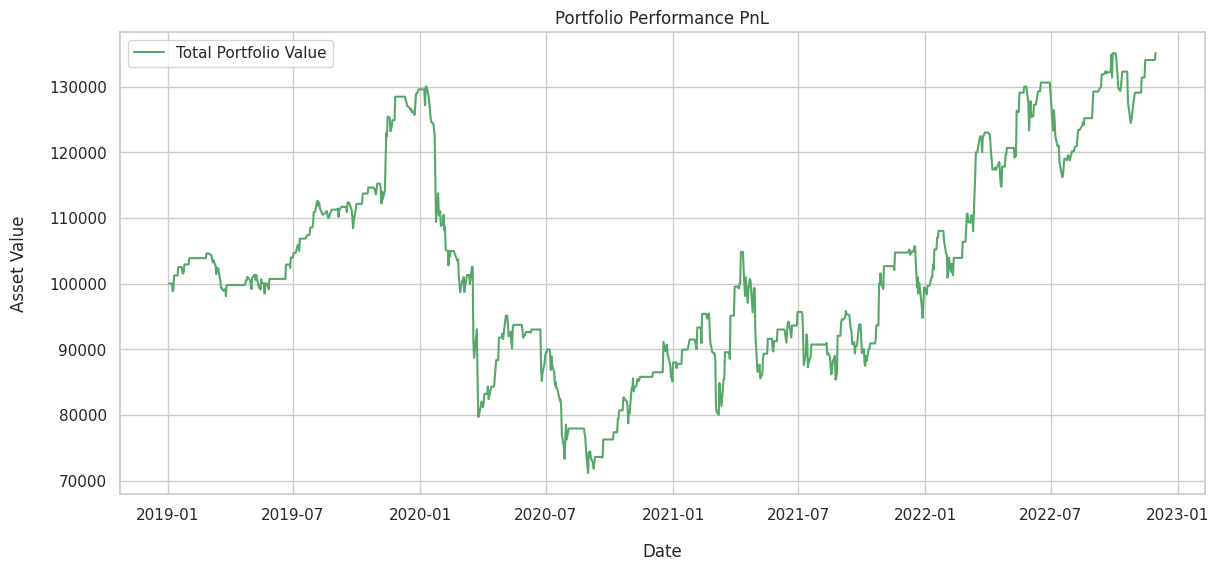

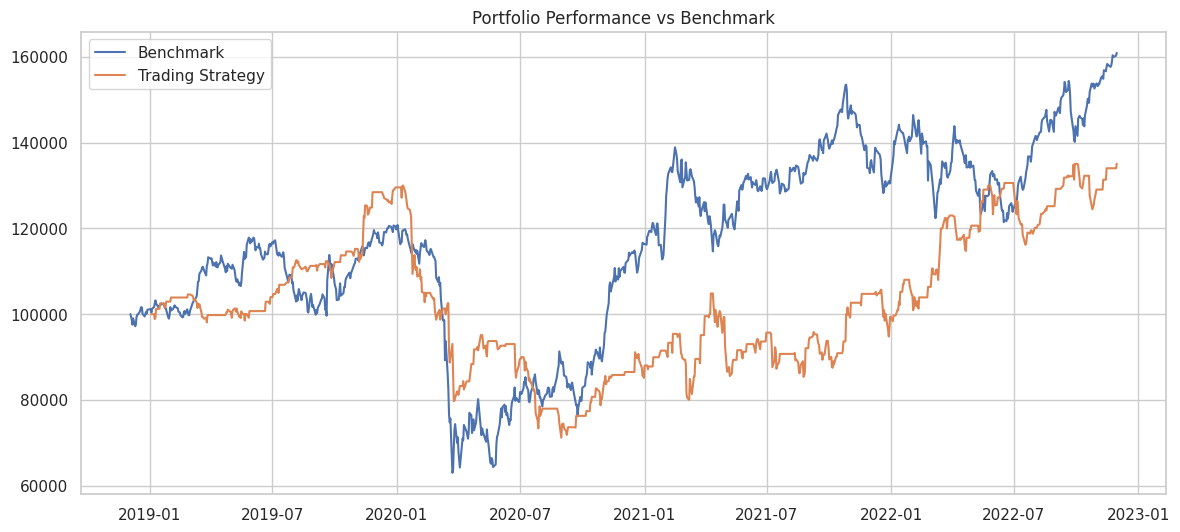

In [78]:
backtesting(dstart,dend)